Colonna temporale trovata: _time
Campo: co2 | Varianza originale: 2774.3656


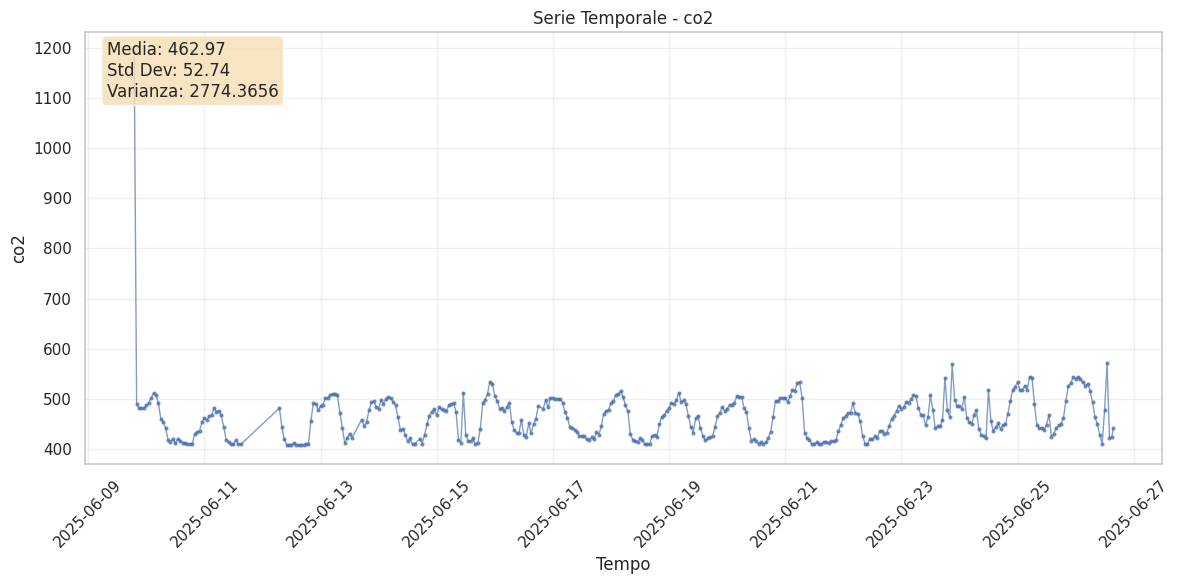

Campo: eco2 | Varianza originale: 36685.4292


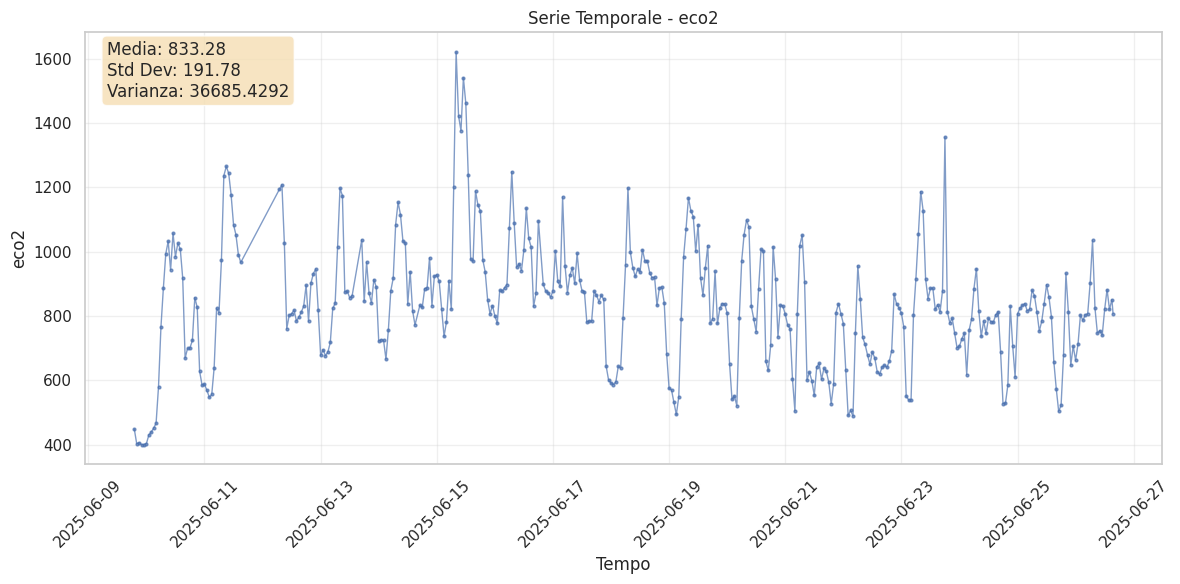

Campo: humidity | Varianza originale: 477.1956
Campo: humidity | Varianza dopo pulizia: 292.6736


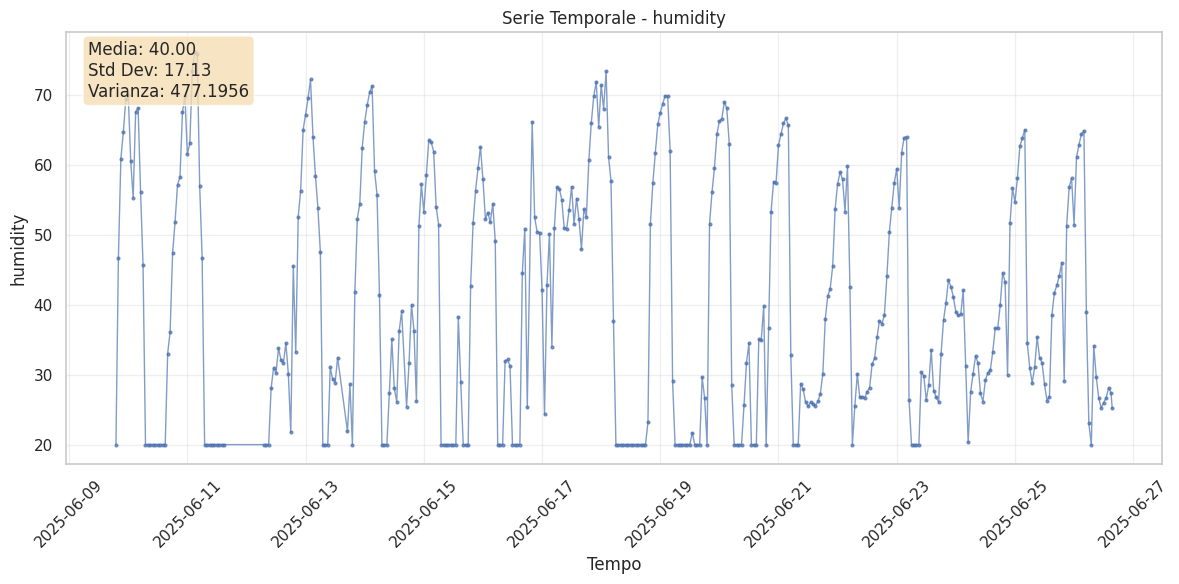

Campo: pm10p0 | Varianza originale: 62.3172


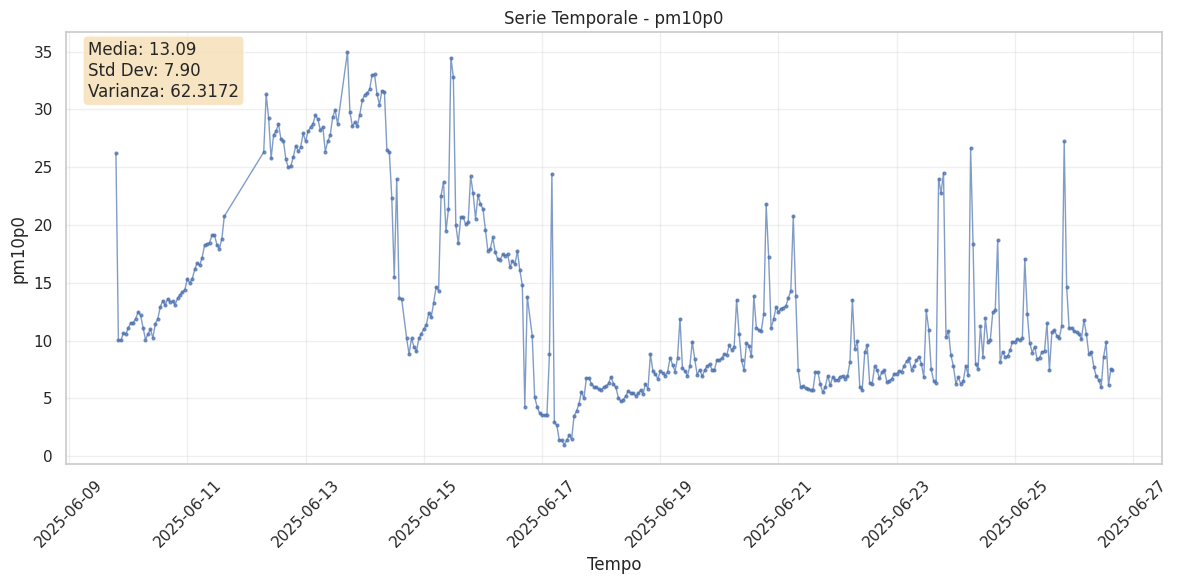

Campo: pm1p0 | Varianza originale: 47.0244


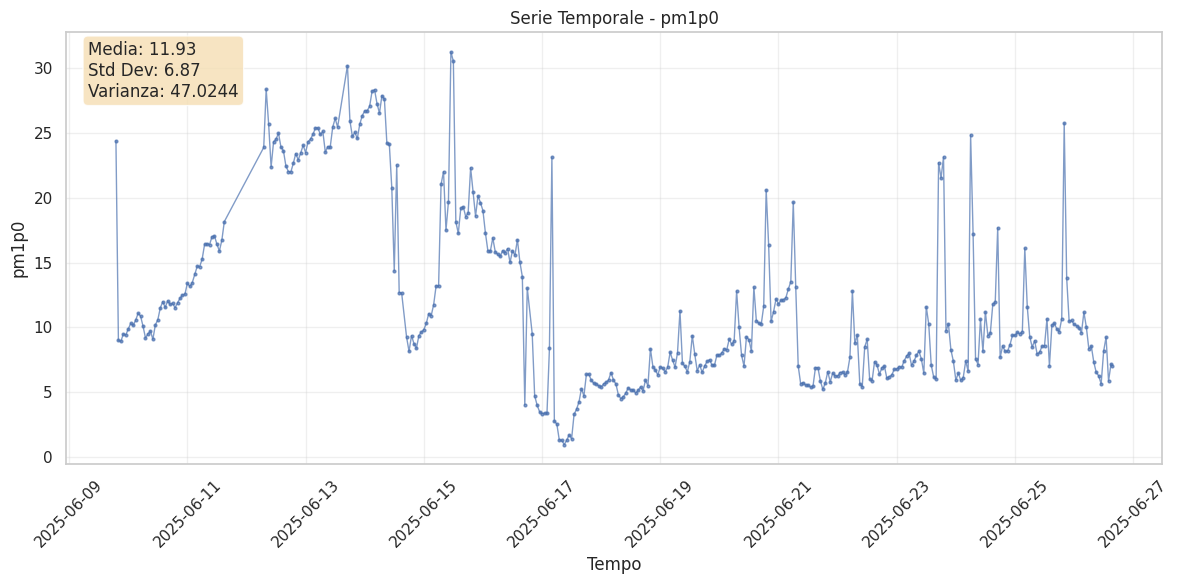

Campo: pm2p5 | Varianza originale: 56.7620


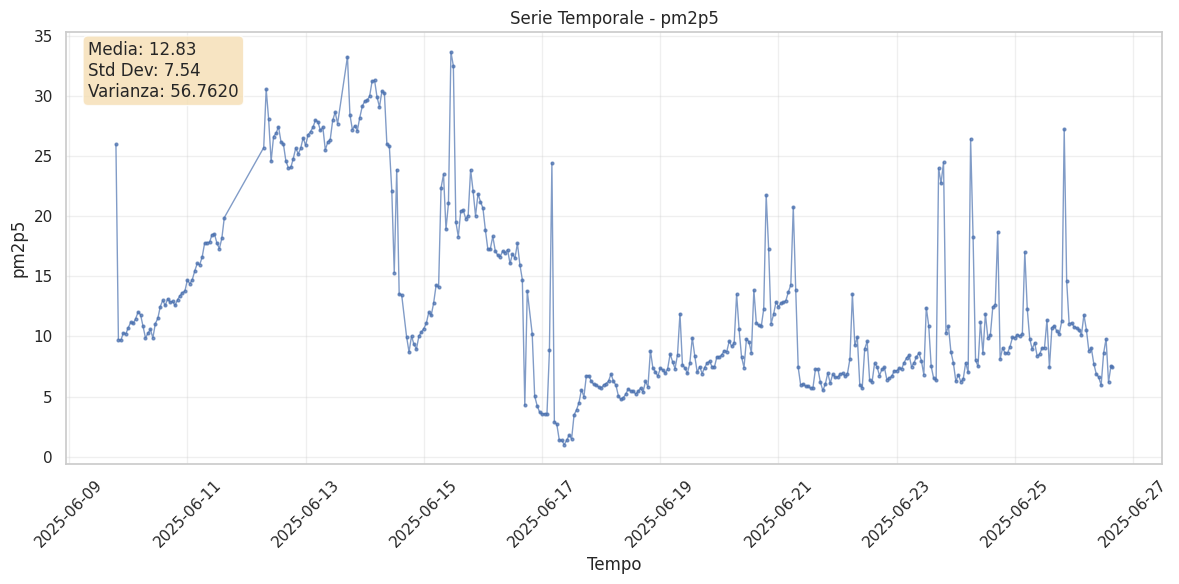

Campo: pm4p0 | Varianza originale: 60.4248


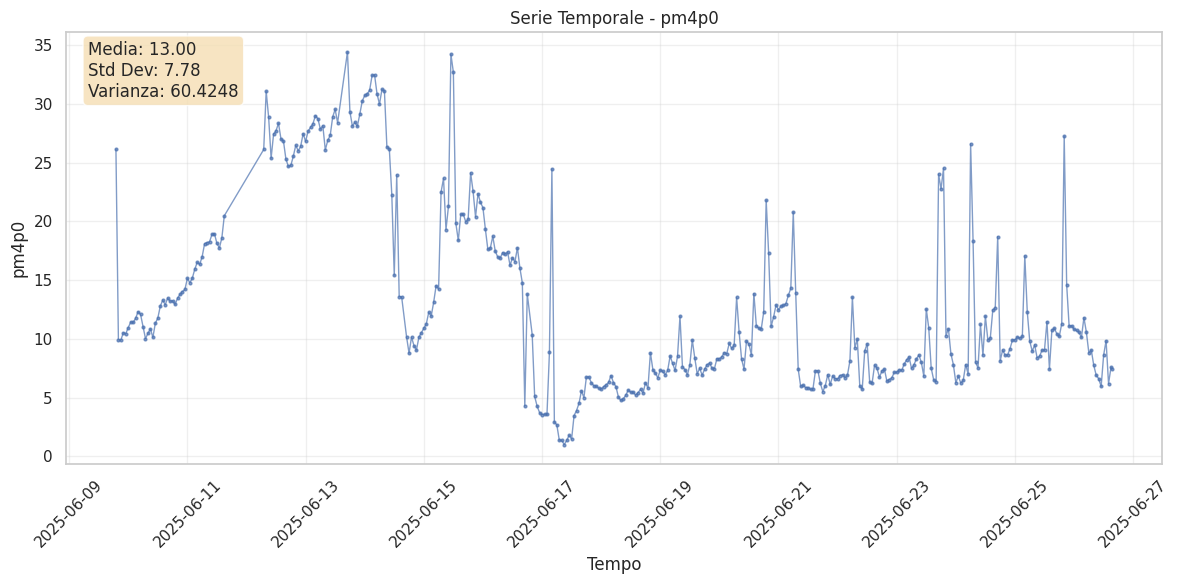

Campo: pressure | Varianza originale: 4.2111


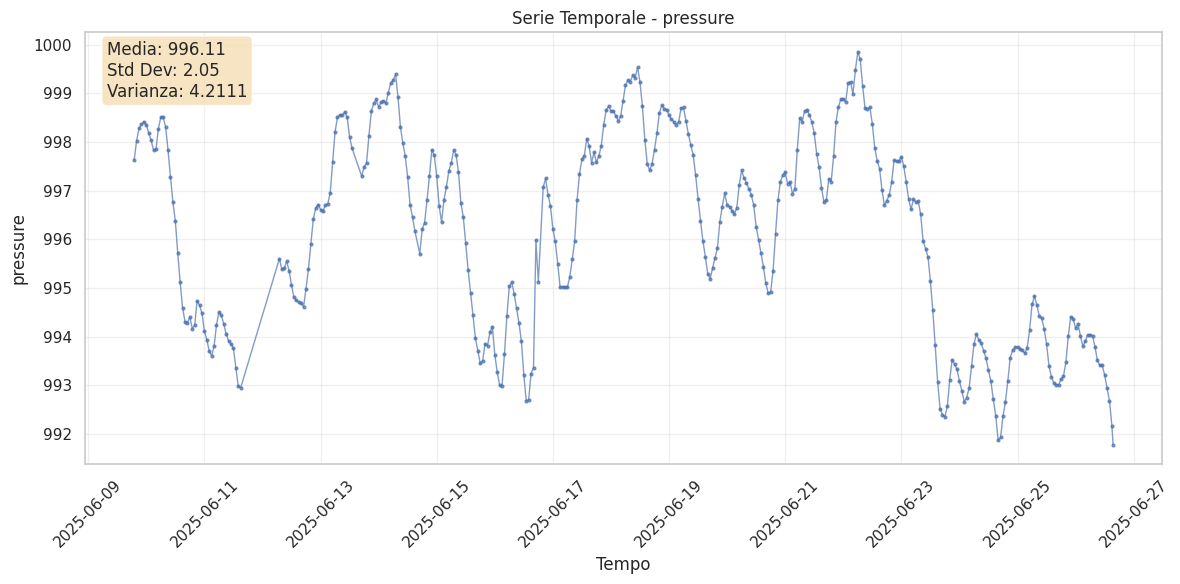

Campo: temperature_avg | Varianza originale: 37.4729


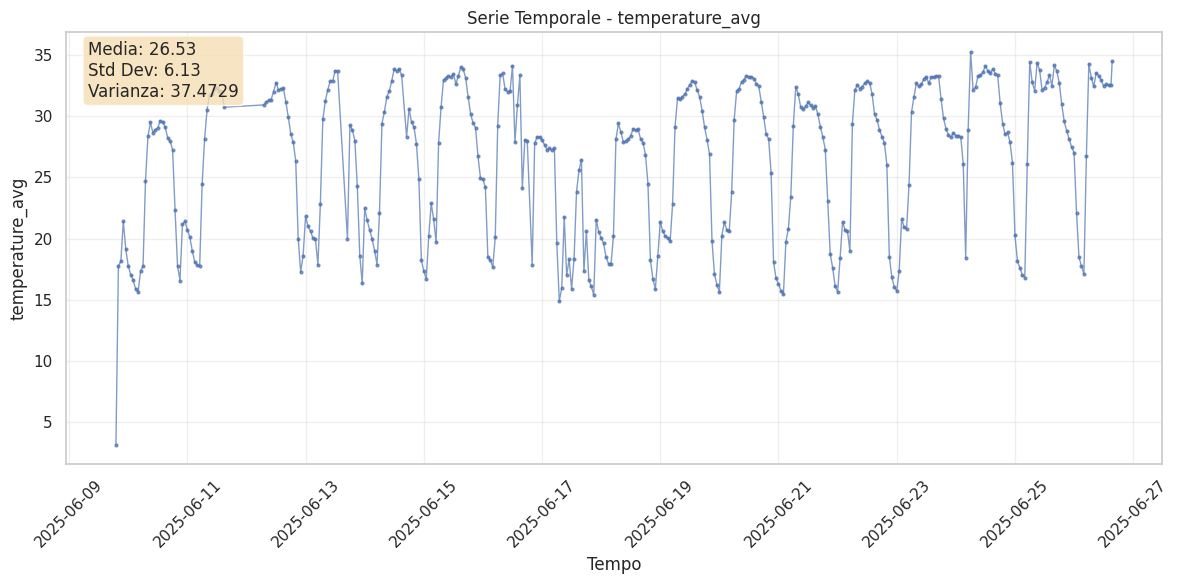

Campo: tvoc | Varianza originale: 336914.5753


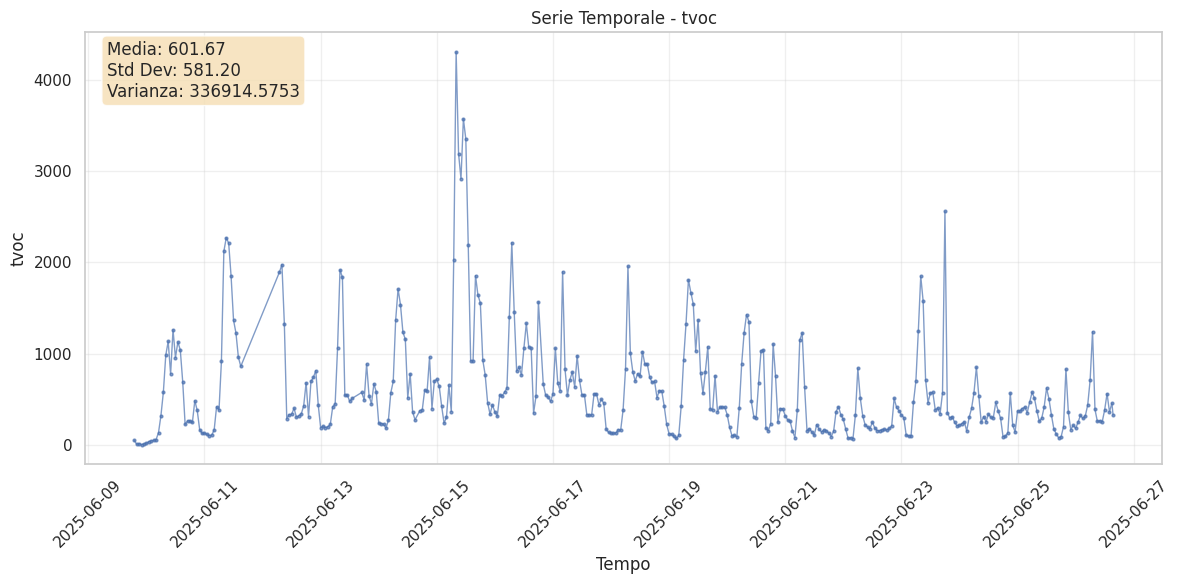

Campo: typical_particle_size | Varianza originale: 0.0018


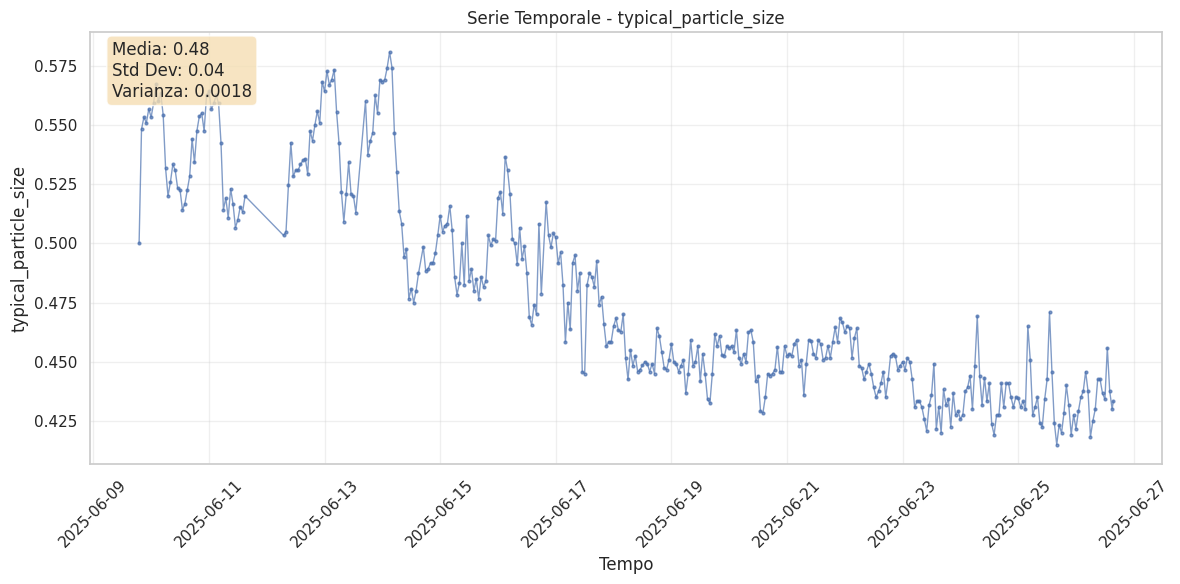


Dataset pulito salvato come 'dataset_pulito.csv' con 4246 righe.
Campi processati: co2, eco2, humidity, pm10p0, pm1p0, pm2p5, pm4p0, pressure, temperature_avg, tvoc, typical_particle_size


In [3]:
# ==============================================================================
# SCRIPT PER ANALISI E VISUALIZZAZIONE DEI DATI DI QUALITÀ DELL'ARIA
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

sns.set_theme(style="whitegrid")

# Caricamento file
nome_file_csv = 'influxdb_data.csv'
if not os.path.exists(nome_file_csv):
    print(f"ERRORE: File '{nome_file_csv}' non trovato.")
    df = None
else:
    df = pd.read_csv(nome_file_csv, comment='#')

# Verifica che il file sia caricato correttamente
if df is not None and {'_field', '_value'}.issubset(df.columns):
    output_data = []

    # Crea cartella per i grafici
    os.makedirs("grafici", exist_ok=True)

    # Converti la colonna temporale (assumendo che si chiami '_time' o 'time')
    time_columns = [col for col in df.columns if 'time' in col.lower()]
    if time_columns:
        time_col = time_columns[0]
        # Use format='ISO8601' and errors='coerce' to handle timestamp variations
        df[time_col] = pd.to_datetime(df[time_col], format='ISO8601', errors='coerce')
        print(f"Colonna temporale trovata: {time_col}")
    else:
        print("ATTENZIONE: Nessuna colonna temporale trovata. I grafici potrebbero non essere ordinati correttamente.")
        time_col = None

    # Itera su ogni tipo di campo (es: temperature, humidity, etc.)
    for field in df['_field'].unique():
        dati_field = df[df['_field'] == field].copy()

        # Ordina per tempo se disponibile
        if time_col:
            dati_field = dati_field.sort_values(time_col)

        # CALCOLA LA VARIANZA PRIMA di applicare modifiche ai dati
        varianza_originale = np.var(dati_field['_value'])
        print(f"Campo: {field} | Varianza originale: {varianza_originale:.4f}")

        # Se humidity, applica soglia minima 20% DOPO aver calcolato la varianza
        if field.lower() == 'humidity':
            dati_field['_value_pulito'] = dati_field['_value'].apply(lambda x: max(x, 20))
            varianza_pulita = np.var(dati_field['_value_pulito'])
            print(f"Campo: {field} | Varianza dopo pulizia: {varianza_pulita:.4f}")
            valore_da_plottare = '_value_pulito'
        else:
            dati_field['_value_pulito'] = dati_field['_value']
            valore_da_plottare = '_value'

        # PLOT COME SERIE TEMPORALE
        plt.figure(figsize=(12, 6))

        if time_col:
            # Serie temporale vera e propria
            plt.plot(dati_field[time_col], dati_field[valore_da_plottare],
                    marker='o', markersize=2, linewidth=1, alpha=0.7)
            plt.xlabel('Tempo')
            plt.xticks(rotation=45)
        else:
            # Se non c'è colonna temporale, usa l'indice
            plt.plot(dati_field.index, dati_field[valore_da_plottare],
                    marker='o', markersize=2, linewidth=1, alpha=0.7)
            plt.xlabel('Indice campione')

        plt.title(f'Serie Temporale - {field}')
        plt.ylabel(field)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Aggiungi statistiche come testo nel grafico
        media = dati_field[valore_da_plottare].mean()
        std_dev = dati_field[valore_da_plottare].std()
        plt.text(0.02, 0.98, f'Media: {media:.2f}\nStd Dev: {std_dev:.2f}\nVarianza: {varianza_originale:.4f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        # Salva il grafico
        plt.savefig(f"grafici/{field}_timeseries.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # GRAFICO AGGIUNTIVO: Istogramma per vedere la distribuzione
        plt.figure(figsize=(8, 5))
        sns.histplot(dati_field[valore_da_plottare], bins=30, kde=True)
        plt.title(f'Distribuzione - {field}')
        plt.xlabel(field)
        plt.ylabel("Frequenza")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"grafici/{field}_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Aggiungi al dataset pulito (usa sempre _value_pulito)
        dati_field['_field'] = field
        dati_field['_value'] = dati_field['_value_pulito']  # Sostituisci con valore pulito
        output_data.append(dati_field[['_field', '_value'] + ([time_col] if time_col else [])])

    # Unisci tutti i dati filtrati e salvati
    df_pulito = pd.concat(output_data, ignore_index=True)
    df_pulito.to_csv("dataset_pulito.csv", index=False)
    print(f"\nDataset pulito salvato come 'dataset_pulito.csv' con {len(df_pulito)} righe.")
    print(f"Campi processati: {', '.join(df['_field'].unique())}")

else:
    print("ERRORE: Il dataset non contiene le colonne '_field' e '_value'.")
    if df is not None:
        print(f"Colonne disponibili: {list(df.columns)}")